## Importing neccessary packages

In [1]:
import pandas as pd
from itertools import *
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
from collections import Counter
import ast
import gc
import holidays
from datetime import date
from scipy.stats import pearsonr
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
import plotly.graph_objects as go

/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

/anaconda2/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



## Loading the Dataset

In [2]:

main_data = pd.read_csv("Movie_Revenue_predictions.csv", parse_dates=['release_date'])
main_data.head(3)

,title,tagline,revenue,budget,genres,homepage,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status
0,Avatar,Enter the World of Pandora.,2787965087,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...","[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released
1,Pirates of the Caribbean: At World's End,"At the end of the world, the adventure begins.",961000000,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released
2,Spectre,A Plan No One Escapes,880674609,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released


In [ ]:
print(f"we have {main_data.shape[0]} rows and {main_data.shape[1]} columns in our dataset \n\n")
print(main_data.info()) ### varaible types
print(f"\n\n\nwe have movies from {min(main_data['release_date'])} to {max(main_data['release_date'])}")
print(main_data['status'].value_counts())
print("\n\nWe also have movies that is not yet release. Lets take a look at these movies\n\n")
tmp = main_data[main_data['status'] != 'Released']
print(f"\n\nthe below movies never release until today falls \ninto Rumored and Post Production category")
tmp[['title']]         


Lets take a look at whats missing and see if we can fill those: 

title                      0
tagline                  844
revenue                    0
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
overview                   3
production_companies       0
production_countries       0
release_date               1
runtime                    2
spoken_languages           0
status                     0
dtype: int64


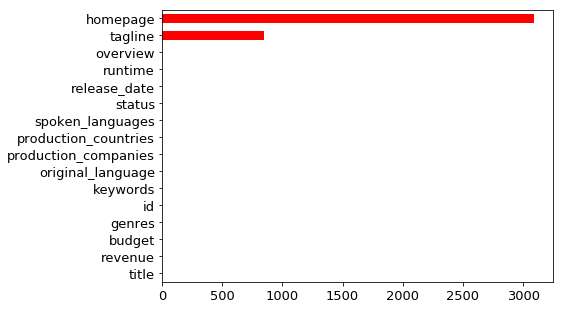

In [3]:
print("\nLets take a look at whats missing and see if we can fill those: \n")
print(main_data.isnull().sum())

fig = plt.figure(figsize=(7, 5))
main_data.isna().sum().sort_values(ascending=True).plot(kind='barh',color='red', fontsize=13)

#### Its observed that HOMEPAGE and TAGLINE have their proportion of missing values as relatively high and hence wont be considered further in our EDA.

In [4]:
main_data = main_data.drop(['homepage', 'tagline'], axis=1)

## Data Imputation

### Imputing missing data on Release Date

In [5]:
#lets impute a release date of a movie which is missing
main_data[main_data['release_date'].isnull()] #1

,title,revenue,budget,genres,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status
4553,America Is Still the Place,0,0,[],380097,[],en,1971 post civil rights San Francisco seemed li...,[],[],NaT,0.0,[],Released


In [6]:
import datetime
x = datetime.datetime(2015, 1, 4)
main_data.loc[main_data['id'] == 380097,'release_date'] = x
main_data.loc[main_data['id'] == 380097] # now its filled

,title,revenue,budget,genres,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status
4553,America Is Still the Place,0,0,[],380097,[],en,1971 post civil rights San Francisco seemed li...,[],[],2015-01-04,0.0,[],Released


### Imputing missing data on Run Time

In [7]:
#lets impute missing runtime
main_data[main_data['runtime'].isnull()]['runtime']

2656   NaN
4140   NaN
Name: runtime, dtype: float64

In [8]:
main_data.loc[main_data['id'] == 370980,'runtime'] = 113
main_data.loc[main_data['id'] == 459488,'runtime'] = 81
main_data[main_data['runtime'].isnull()] ##done


,title,revenue,budget,genres,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status


### Imputing missing data on OverView

In [9]:
main_data[main_data['overview'].isnull()]

,title,revenue,budget,genres,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status
2656,Chiamatemi Francesco - Il Papa della gente,0,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,NaN,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,113.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released
4140,"To Be Frank, Sinatra at 100",0,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,NaN,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,81.0,[],Released
4431,Food Chains,0,913000,"[{""id"": 99, ""name"": ""Documentary""}]",292539,[],de,NaN,[],[],2014-04-26,83.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released


In [10]:
main_data.loc[main_data['id'] == 370980,'overview'] = "The life of Jorge Mario Bergoglio, from his youth to his election as head of the Roman Catholic Church."
main_data.loc[main_data['id'] == 459488,'overview'] = "An exploration of how singer and actor Frank Sinatra became one of the biggest stars of the 20th century while remaining, in his heart, a normal person."
main_data.loc[main_data['id'] == 292539,'overview'] = "Farmworkers in Immokalee, Fla., launch a hunger strike at the headquarters of Publix supermarkets to protest poor wages and working conditions."
main_data[main_data['overview'].isnull()] ##done

,title,revenue,budget,genres,id,keywords,original_language,overview,production_companies,production_countries,release_date,runtime,spoken_languages,status


### Correcting Release year values
#### All release years greater than 2019 were corrected.

In [11]:
# Now lets investigate about the movies which has released date after 2019
main_data.loc[main_data['release_date'].idxmax(),['title','release_date']]
#google says that this movie was release in 1968 not in 2068. 
# we have make some additional columns to make these dates correct
def correcting_dates(df):    
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    df['release_year']=np.where(df['release_year']> 2019, df['release_year']-100, df['release_year'])
    year = df["release_year"].astype(int).copy().astype(str)
    month=df['release_month'].astype(int).copy().astype(str)
    day=df['release_day'].astype(int).copy().astype(str) 
    df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df
main_data = correcting_dates(main_data)

In [12]:
## now lets check if everything is good with dates.
#main_data.sort_values(by='release_date', ascending=False).head(10)[['title','revenue','budget','release_date']]
## maximum release date is not 2068 anymore

## Feature Engineering

In [13]:
def feature_engineering(df):
   
    ## title
    df['title_word_count'] = df['title'].str.split().str.len()
    
    ## genres
    df['genres'] = df['genres'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
    df['all_genres'] = df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
    list_of_genres = list(df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
    top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common()] #we may create more sparse data using all genre
    for g in top_genres:
        
        df[ g + '_genre'] = df['all_genres'].apply(lambda x: 1 if g in x else 0)
        
    ## original language
    df['eng_language'] = 0 
    df.loc[ df['original_language'] == "en" ,'eng_language'] = 1
    
    
    ## overview
    df['overview_word_count'] = df['overview'].str.split().str.len()
    
    
    ## production companies
    df['num_production_companies'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    
    
    ## production countries
    df['num_production_countries'] = df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    
    ## spoken languages
    df['num_spoken_languages'] = df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
    
    
    ## runtime 
    df['meanruntimebyyear'] = df.groupby("release_year")["runtime"].transform('mean')
    
    ## number of clashes
    hit_movies = df[df['revenue'] >=  df.revenue.quantile(0.60)] #38 million
    hit_movies_dates = list(hit_movies['release_date'])
    hit_movies_title = list(hit_movies['title'])
    upp = pd.Timedelta('15 days')
    low = pd.Timedelta('-15 days')
    same = pd.Timedelta('0 days')
    
    def number_of_clashes(row):
        if row['title'] in hit_movies_title:
            a = 0
            return a
        else:

            for i in hit_movies_dates:
                ans = row['release_date'] - i
                num_clashes = 0
                if low <= ans <= upp:
                    num_clashes += 1
                else:
                    num_clashes += 0
                return num_clashes
    
    df['Num_clash'] = df.apply(lambda row : number_of_clashes(row), axis=1)
    
    
    
    ## binned release year into decades (binning helps)
    
    bins = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
    labels = [1,2,3,4,5,6,7,8,9,10]
    df['binned_release_year'] = pd.cut(df['release_year'], bins=bins, labels=labels)
    
    
    ## BUDGET ##########################
    ## there are 1037 missing budget in our dataset. lets fill that mean budget value by year
    
    mean_budget_year = df.groupby("release_year")["budget"].mean()
    
    df.drop([4255], inplace = True) ## this row was causing a problem. 
    df['meanbudgetbyyear'] = df.groupby("release_year")["budget"].transform('mean')
    df['medianbudgetbyyear'] = df.groupby("release_year")["budget"].transform('median')

    #now binning budget
    bins = list(range(0,380000000, 5000000)) #1 bin = 5 mil
    labels = list(range(1,76,1))
    df['binned_budget'] = pd.cut(df['budget'], bins=bins, labels=labels)
    
    ##inflation budget over a year, so we will see rise in mean year budget with respect to first year mean budget in our dataset
    df['inflated_budget_year'] = df.apply(lambda row : (row['meanbudgetbyyear'] - 245000)/row['meanbudgetbyyear'] , axis=1)
    
    ##inflation budget over a decade, so we will see rise in mean decade budget with respect to first decade mean budget
    df['meanbudgetbydecade'] = df.groupby("binned_release_year")["budget"].transform('mean')
    df['inflated_budget_decade'] = df.apply(lambda row : (row['meanbudgetbydecade'] - 19514600)/row['meanbudgetbydecade'] , axis=1)
    
    ## inflation budget by last year
    def inflated_budget_last_year(row):
        if row['release_year'] == 1925:
            return 0
        elif row['release_year'] == 1927 or 1929 or 1932:
            return 1
        else:
            mean_budget_last_year = mean_budget_year(row['release_year'] - 1)
            ans = (row['meanbudgetbyyear'] - mean_budget_last_year) / row['meanbudgetbyyear']
            return ans
    
    df['inflation_last_year'] = df.apply(lambda row : inflated_budget_last_year(row), axis=1)
    
    
    ## budget year ratio
    df['budget_year_ratio'] = df['budget'] / (df['release_year'] * df['release_year'])
    
    ##budget runtime ratio
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    ##budget to mean year budget
    df['budget_to_mean_year'] = df['budget'] / df['meanbudgetbyyear']
    
    ## runtime to mean year 
    df['runtime_to_meanruntime'] = df['runtime'] / df['meanruntimebyyear']
    
    ## log transform budget
    df['log_budget'] = np.log1p(df['budget'])  ## can also use np.log() as we dont have tiny values and np.log(0) cause an error
    
    ## movie released ?
    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 
    
    ## CHECKING FOR HOLIDAY RELEASE
    us_holidays = holidays.UnitedStates()
    df['USholidayreleased'] = df['release_date'].apply(lambda x: 1 if x in us_holidays else 0)
    
    ## Keywords
    df['num_Keywords'] = df['keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['keywords'] = df['keywords'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    indx_of_top_movies = []
    indx_of_top_movies = list(df.sort_values(by=["revenue"], ascending=[False]).head(500).index.values)

    list_of_keywords = list(df['keywords'][indx_of_top_movies].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(100)
    most_common_keywords = [i[0] for i in most_common_keywords]

    whole_list = []
    for num_1 in df['keywords'].index.values:
        list_keys = []
        if num_1 != 4255:
            for num in range(0, len(df['keywords'][num_1])):
                list_keys.append(list(df['keywords'][num_1][num].values())[1])
            whole_list.append(list_keys)
        
    df.insert(1, "keys", whole_list, True)
    percentage = []
    for num in df['keys'].index.values:
        p = 0
        p = (len(set(df.loc[num]['keys']).intersection(set(most_common_keywords)))*100/ len(set(most_common_keywords)))
        percentage.append(p)
    df.insert(1, "keys_Percent", percentage, True)
    
    df = df.drop(['id','genres','overview','runtime'
    ,'production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','keywords','original_language', 'keys','all_genres'],axis=1)
    
    
    return df    

In [14]:
tmp = feature_engineering(main_data)

## Testing relationship statistics among the numerical and categorical variables with the target variable - Revenue

In [15]:

num_variable = ['keys_Percent', 'budget', 'release_year', 'release_month',
       'release_day', 'release_quarter', 'release_dow', 'title_word_count',
       'num_genres', 'overview_word_count',
       'num_production_companies', 'num_production_countries',
       'num_spoken_languages', 'meanruntimebyyear', 'Num_clash',
       'meanbudgetbyyear', 'medianbudgetbyyear', 'inflated_budget_year',
       'meanbudgetbydecade', 'inflated_budget_decade', 'inflation_last_year',
       'budget_year_ratio', 'budget_to_runtime', 'budget_to_mean_year',
       'runtime_to_meanruntime', 'log_budget',
        'num_Keywords','revenue']
flag_variable = ['Drama_genre', 'Comedy_genre', 'Thriller_genre',
       'Action_genre', 'Romance_genre', 'Adventure_genre', 'Crime_genre',
       'Science Fiction_genre', 'Horror_genre', 'Family_genre',
       'Fantasy_genre', 'Mystery_genre', 'Animation_genre', 'History_genre',
       'Music_genre', 'War_genre', 'Documentary_genre', 'Western_genre',
       'Foreign_genre', 'TV Movie_genre',
         'eng_language','isMovieReleased', 'USholidayreleased','binned_release_year', 'binned_budget']

In [16]:
def anova_stat(df, a, b):
    F, p = stats.f_oneway(df[df[b] == 1][a],
                      df[df[b] == 0][a])
    return p

In [17]:
signi_num_var = []
for col in num_variable:
    p, f = pearsonr(tmp['revenue'], tmp[col])
    if p > .3:
        signi_num_var.append(col) 
        
signi_cat_var = []
for col in flag_variable:
    p = anova_stat(tmp, 'revenue', col)
    if p < .05:
        signi_cat_var.append(col)
        
complete_variable_list = signi_num_var + signi_cat_var  

/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2923: RuntimeWarning:

invalid value encountered in double_scalars



In [18]:
final_data = tmp[complete_variable_list]

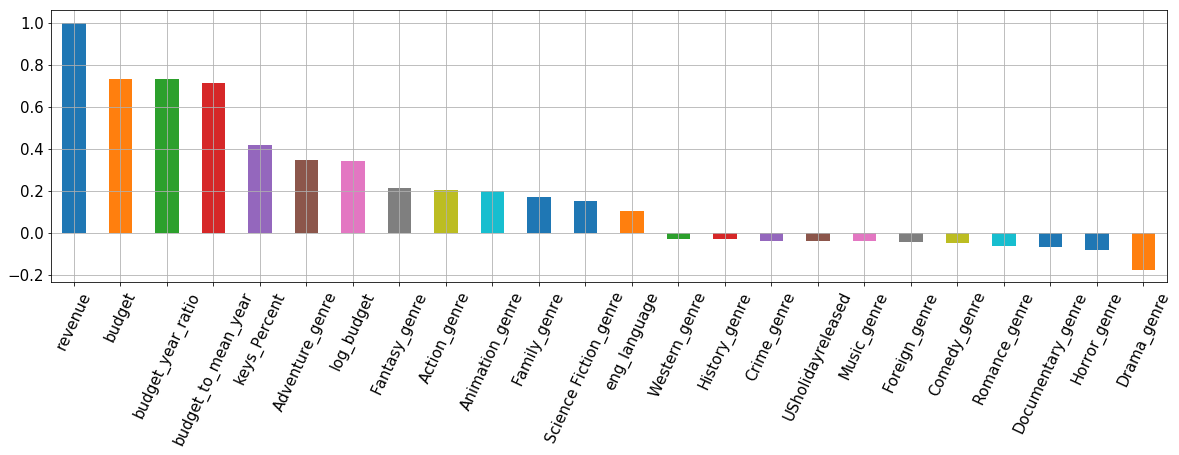

In [19]:

final_data[final_data.columns[0:]].corr()['revenue'][:].sort_values(ascending=False).plot(
    kind='bar', figsize=(20, 5), fontsize=15, rot=65, grid=True)



## Exploratory Data Analysis on the final set of columns

### Top 10 movies with highest revenue

In [20]:
print("Top 10 movies with highest revenue is:")
main_data.sort_values(by='revenue', ascending=False).head(10)[['title','revenue','budget','release_date']]

Top 10 movies with highest revenue is:


,title,revenue,budget,release_date
0,Avatar,2787965087,237000000,2009-12-10
25,Titanic,1845034188,200000000,1997-11-18
16,The Avengers,1519557910,220000000,2012-04-25
28,Jurassic World,1513528810,150000000,2015-06-09
44,Furious 7,1506249360,190000000,2015-04-01
7,Avengers: Age of Ultron,1405403694,280000000,2015-04-22
124,Frozen,1274219009,150000000,2013-11-27
31,Iron Man 3,1215439994,200000000,2013-04-18
546,Minions,1156730962,74000000,2015-06-17
26,Captain America: Civil War,1153304495,250000000,2016-04-27


### Top 10 movies with highest budget

In [21]:
print("\n\nTop 10 movies with highest budget is:")
main_data.sort_values(by='budget', ascending=False).head(10)[['title','revenue','budget','release_date']]



Top 10 movies with highest budget is:


,title,revenue,budget,release_date
17,Pirates of the Caribbean: On Stranger Tides,1045713802,380000000,2011-05-14
1,Pirates of the Caribbean: At World's End,961000000,300000000,2007-05-19
7,Avengers: Age of Ultron,1405403694,280000000,2015-04-22
10,Superman Returns,391081192,270000000,2006-06-28
4,John Carter,284139100,260000000,2012-03-07
6,Tangled,591794936,260000000,2010-11-24
5,Spider-Man 3,890871626,258000000,2007-05-01
13,The Lone Ranger,89289910,255000000,2013-07-03
46,X-Men: Days of Future Past,747862775,250000000,2014-05-15
22,The Hobbit: The Desolation of Smaug,958400000,250000000,2013-12-11


### Comparing the budget and revenue of old and new movies per decade 

Text(0,0.5,'Revenue (100 million dollars)')

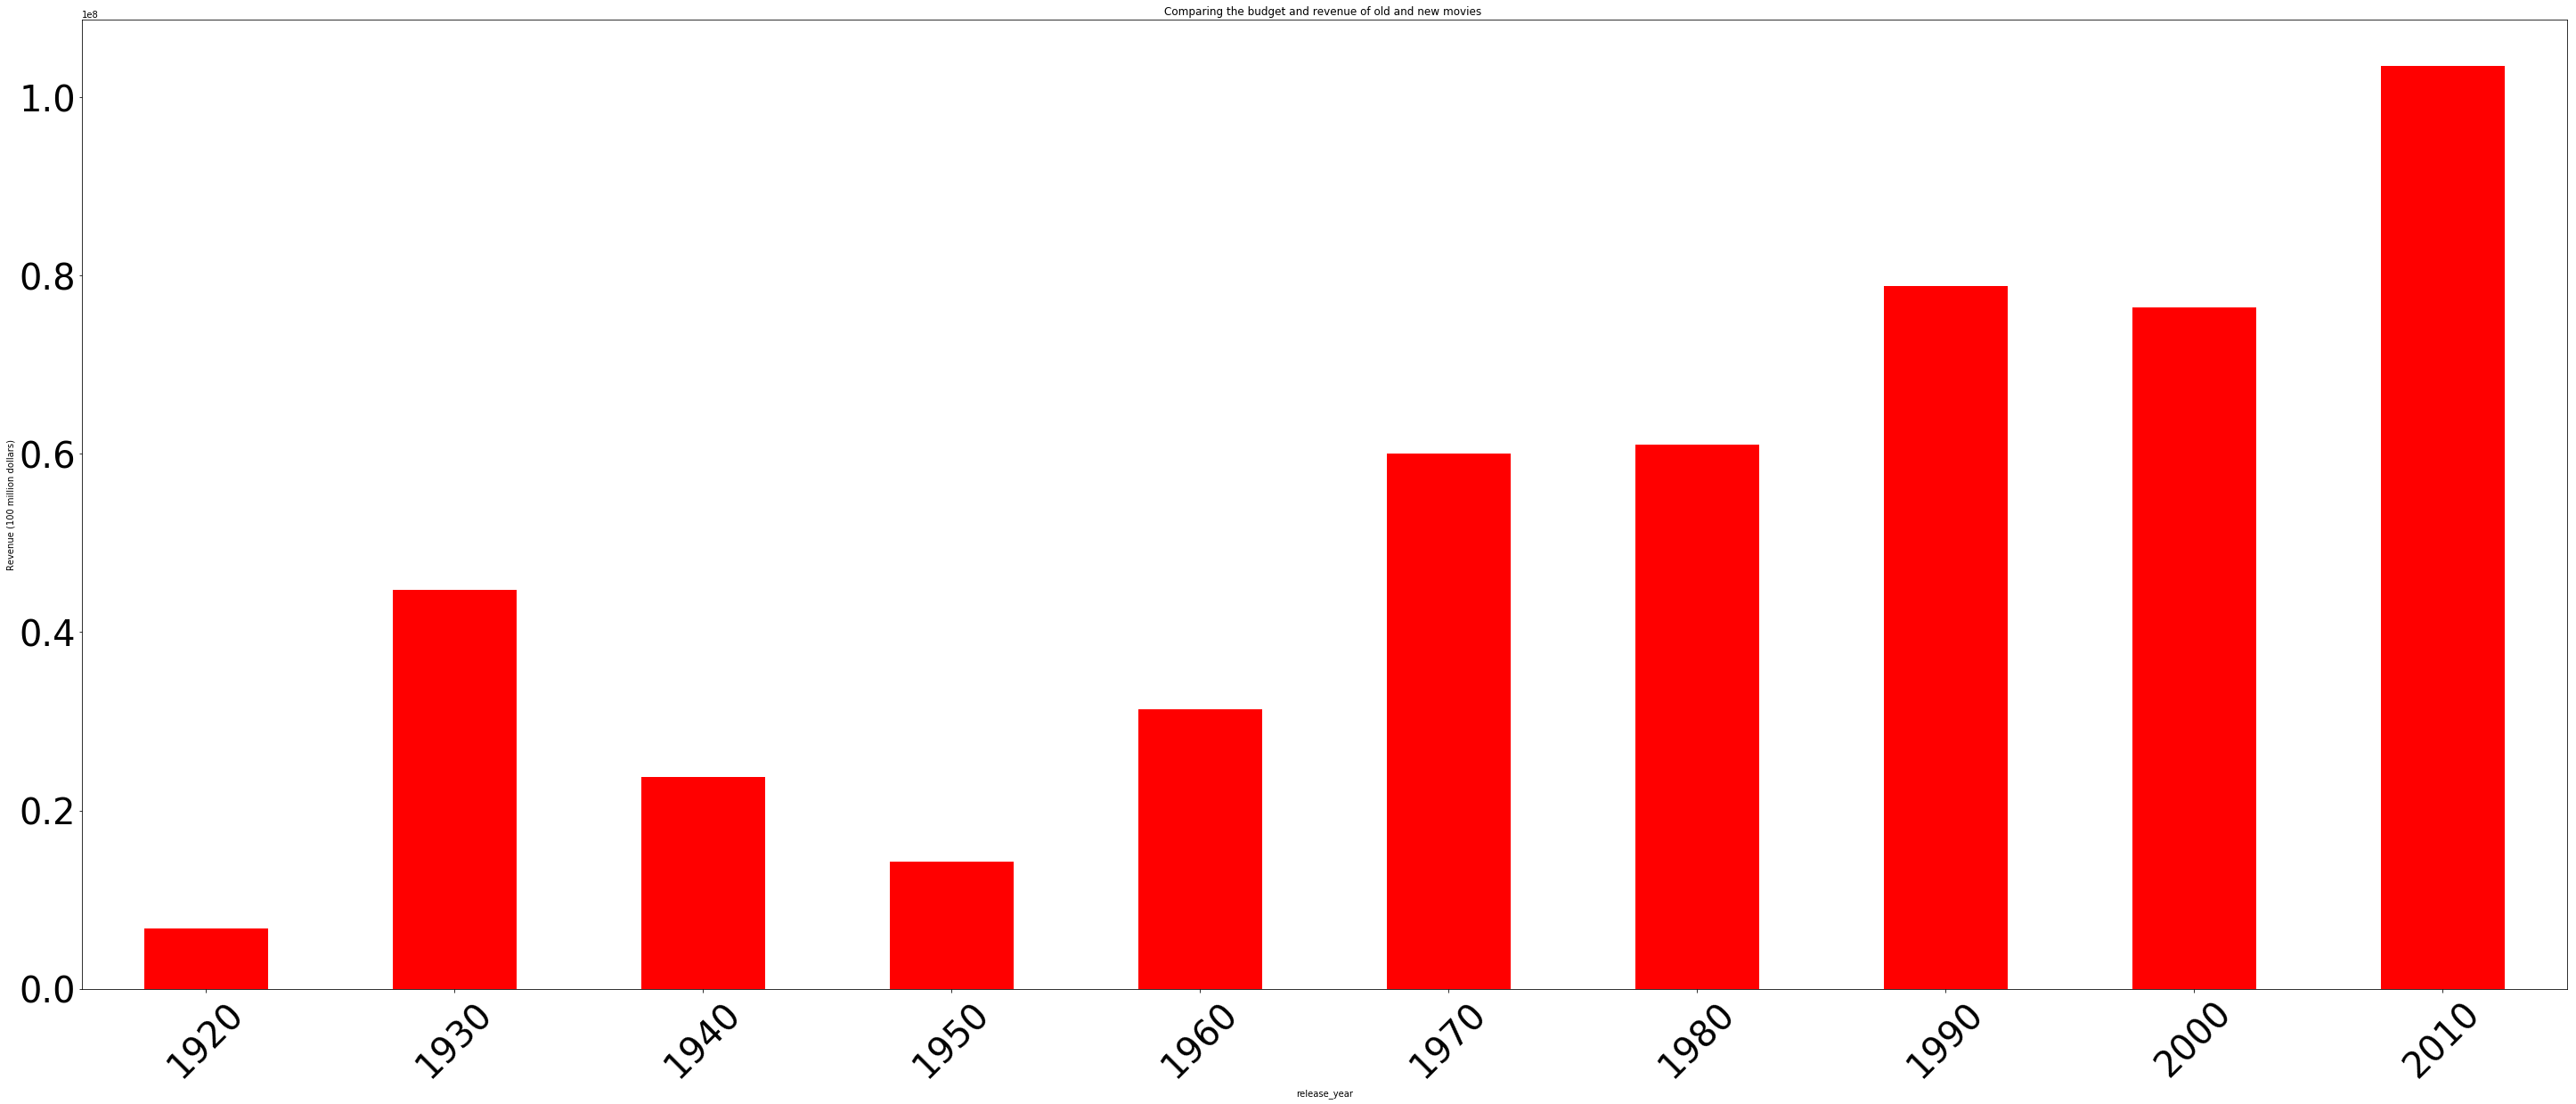

In [22]:
fig = plt.figure(figsize=(50,20))
main_data.groupby((main_data.release_year//10)*10).agg('mean')['revenue'].plot(kind='bar',color='red',
                                                                               rot=45, title = "Comparing the budget and revenue of old and new movies ", fontsize=40)
plt.ylabel('Revenue (100 million dollars)')


In the above plot we are looking at the mean revenue of the movies per year. 

We can clearly see that revenue of the new movies(movies released after 2000)are alot more than the old movies(movies released before 2000) just because of the factors like increase in ticket prices over the years, promotions, increase in number of screens and digital platforms etc.
Also due to less number and blockbusters movies released earlier the mean is highest for some years.

In [29]:
fig = make_subplots(rows=1, cols=2)



fig = px.scatter_matrix(main_data, dimensions=["runtime", "budget", "revenue"], 
                        color="release_year", hover_data=(['title','budget']))
fig.show()


From the above plot it is clear that there is no linear correlation between runtime and revenue. 

We can see that if the budget increases then revenue also increases, But movies like "Pirates of the caribbean : on stranger tides"(right most point on plot) had spent most but did not have highest revenue. we can also easily point out blockbuster movies(Titanic, Avatar) from the above plot based on their revenue and budget. Also most of the movies with highest budget are released around 1990 or after 2000 due to growth of film industries.

In [ ]:
tmp = main_data[['budget','runtime','release_year','release_month','release_dow','revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tmp.corr(), annot=True)
plt.show()

There is strong correlation between budget and revenue following with runtime. 


Now lets take a look at genres column

In [ ]:
dict_columns = ['genres', 'production_companies',
                'production_countries', 'spoken_languages', 'keywords']
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
main_data = text_to_dict(main_data)

In [ ]:
##For genres column

tmp_df = pd.DataFrame()
tmp_df['genres'] = main_data['genres']    
tmp_df['num_genres'] = tmp_df['genres'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
tmp_df['all_genres'] = tmp_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
list_of_genres = list(tmp_df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(20)] #we may create more sparse data using all genre
for g in top_genres:
    tmp_df[ g + '_genre'] = tmp_df['all_genres'].apply(lambda x: 1 if g in x else 0)
tmp_df.drop(['genres'], axis=1)
main_data.drop(['genres'], axis = 1)
main_data = pd.concat([main_data, tmp_df], axis=1) #genres column processing Done.


top_genres = Counter([i for j in list_of_genres for i in j]).most_common() #all possible genres
fig = plt.figure(figsize=(10, 6))
data=dict(top_genres)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='lightblue')
plt.xlabel('Count')
plt.title('Movie Genre Count')
plt.show()



In [ ]:
fig = px.histogram(main_data, x="num_genres")
fig.show()

Most of the movies of our dataset have mixture of 2 to 4 genre type 

In [ ]:
fig = px.scatter(main_data, x="num_genres", y="revenue", color="budget", hover_data=(['title','all_genres']))
fig.show()

The above plot shows us that having mixture 3 to 4 genre type result in good revenue but we also have to take note that most of the movies in our dataset have mixture of 2 to 3 genre type.

In [ ]:
main_data.columns

In [ ]:
##For production companies column
import gc
del tmp_df
gc.collect()
tmp_df = pd.DataFrame()
tmp_df['production_companies'] = main_data['production_companies']    
tmp_df['num_production_companies'] = tmp_df['production_companies'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
tmp_df['all_production_companies'] = tmp_df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
list_of_companies = list(tmp_df['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)] #we may create more sparse data using all genre
for g in top_companies:
    tmp_df[ g + '_company'] = tmp_df['all_production_companies'].apply(lambda x: 1 if g in x else 0)
tmp_df.drop(['production_companies'], axis=1)
main_data.drop(['production_companies'], axis = 1)
main_data = pd.concat([main_data, tmp_df], axis=1) #production_companies column processing Done.

top_companies = Counter([i for j in list_of_companies for i in j]).most_common(30) #top 30 possible companies
fig = plt.figure(figsize=(15, 10))
data=dict(top_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='lightblue')
plt.xlabel('Count')
plt.title('production companies Count')
plt.show()

fig = px.histogram(main_data, x="num_production_companies")
fig.show()

fig = px.scatter(main_data, x="num_production_companies", y="revenue", color="budget", hover_data=(['title']))
fig.show()

In [ ]:
##For production countries column

del tmp_df
gc.collect()
tmp_df = pd.DataFrame()
tmp_df['production_countries'] = main_data['production_countries']    
tmp_df['num_production_countries'] = tmp_df['production_countries'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
tmp_df['all_production_countries'] = tmp_df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
list_of_countries = list(tmp_df['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(15)] #we may create more sparse data using all genre
for g in top_countries:
    tmp_df[ g + '_country'] = tmp_df['all_production_countries'].apply(lambda x: 1 if g in x else 0)
tmp_df.drop(['production_countries'], axis=1)
main_data.drop(['production_countries'], axis = 1)
main_data['num_production_countries'] = tmp_df['num_production_countries']
#main_data = pd.concat([main_data, tmp_df], axis=1) #production_country column processing Done.

top_countries = Counter([i for j in list_of_countries for i in j]).most_common(15) #top 15 possible countries
fig = plt.figure(figsize=(10, 6))
data=dict(top_countries)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='lightblue')
plt.xlabel('Count')
plt.title('production countries Count')
plt.show()

fig = px.histogram(main_data, x="num_production_countries")
fig.show()

fig = px.scatter(main_data, x="num_production_countries", y="revenue", color="budget", hover_data=(['title']))
fig.show()

In [ ]:
##For spoken languages column

del tmp_df
gc.collect()
tmp_df = pd.DataFrame()
tmp_df['spoken_languages'] = main_data['spoken_languages']    
tmp_df['num_spoken_languages'] = tmp_df['spoken_languages'].apply(lambda x: len(x) if x != {} else 0) #summation of number of genres
tmp_df['all_spoken_languages'] = tmp_df['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '') #all possible genres in one column\
list_of_lan = list(tmp_df['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values) ##list of all genres in every row #20
top_lan = [m[0] for m in Counter([i for j in list_of_lan for i in j]).most_common(15)] #we may create more sparse data using all genre
for g in top_lan:
    tmp_df[ g + '_lan'] = tmp_df['all_spoken_languages'].apply(lambda x: 1 if g in x else 0)
tmp_df.drop(['spoken_languages'], axis=1)
main_data.drop(['spoken_languages'], axis = 1)
main_data['num_spoken_languages'] = tmp_df['num_spoken_languages']
#main_data = pd.concat([main_data, tmp_df], axis=1) #spoken_languages column processing Done.

top_lan = Counter([i for j in list_of_lan for i in j]).most_common(15) #top 15 possible countries
fig = plt.figure(figsize=(10, 6))
data=dict(top_lan)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='lightblue')
plt.xlabel('Count')
plt.title('production countries Count')
plt.show()

fig = px.histogram(main_data, x="num_spoken_languages")
fig.show()

fig = px.scatter(main_data, x="num_spoken_languages", y="revenue", color="budget", hover_data=(['title']))
fig.show()

del tmp_df
gc.collect()

In [ ]:
##For keywords column


list_of_keywords = list(main_data['keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_keywords)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='green')
plt.xlabel('Count')
plt.title('Top 20 Most Common Keyword Count')
plt.show()

In [ ]:

len(main_data.columns)

In [30]:
def sq(x):
    return x*x

In [ ]:
def rec(func, seq):
    return [func(seq[0])] + 

In [33]:
d = {2:3, 5:6}
e = {}
e.update(d)

In [34]:
e

{2: 3, 5: 6}

In [40]:
id(e)

112450394944

In [41]:
id(d)

112450393824

In [42]:
e = {}

In [43]:
d

{2: 3, 5: 6}

In [44]:
e = dict(d)

In [45]:
e

{2: 3, 5: 6}

In [46]:
id(e)

112404842488

In [47]:
id(d)

112450393824

In [48]:
del d[2]

In [49]:
d

{5: 6}

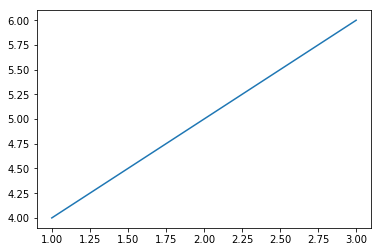

In [61]:
import matplotlib.pyplot as plt

x = (1,2,3)
y = (4, 5, 6)
plt.plot(x,y)
plt.show()

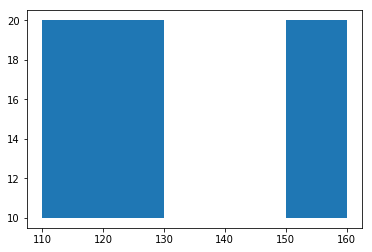

In [66]:
plt.broken_barh([(110, 20), (150, 10)], (10, 10))